## SETUP

In [4]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
from scipy.spatial.distance import pdist, squareform
import seaborn as sns
from collections import namedtuple

##Matrix Grouping Code CREDIT TO erikm0111

def sumRow(matrix, i):
    return np.sum(matrix[i,:])
 
def determineRow(matrix):
    maxNumOfOnes = -1
    row = -1
    for i in range(len(matrix)):
        if maxNumOfOnes < sumRow(matrix, i):
            maxNumOfOnes = sumRow(matrix, i)
            row = i
    return row
 
def addIntoGroup(matrix, ind):
    change = True
    indexes = []
    for col in range(len(matrix)):
        if matrix[ind, col] == 1:
            indexes.append(col)
    while change == True:
        change = False
        numIndexes = len(indexes)
        for i in indexes:
            for col in range(len(matrix)):
                if matrix[i, col] == 1:
                    if col not in indexes:
                        indexes.append(col)
        numIndexes2 = len(indexes)
        if numIndexes != numIndexes2:
            change = True
    return indexes
 
def deleteChosenRowsAndCols(matrix, indexes):
    for i in indexes:
        matrix[i,:] = 0
        matrix[:,i] = 0
    return matrix
def categorizeIntoClusters(matrix):
    groups = []
    while np.sum(matrix) > 0:
        group = []
        row = determineRow(matrix)
        indexes = addIntoGroup(matrix, row)
        groups.append(indexes)
        matrix = deleteChosenRowsAndCols(matrix, indexes)
    return groups

##Personal functions

def buildThreshholdMatrix(prev, threshold):
	numOfSamples = len(prev)
	matrix = np.zeros(shape=(numOfSamples, numOfSamples))
	for i in range(len(matrix)):
		for j in range(len(matrix)):
			dist = prev[i,j]
			if dist > threshold:
				matrix[i,j] = 1
	return matrix

def labelCluster(df, group, cluster):
#     print(group)
    for i in range(len(group)):
        for j in range(len(group[i])):
            df.loc[group[i][j],cluster] = i
    return df

def getClusterName(threshold):
    return 'cluster_t{}'.format(i)
        
def addGroupsToDF(df, group, thresh):
    cluster = getClusterName(thresh)
    df[cluster] = 0
    for i in range(len(group)):
        for j in range(len(group[i])):
            df.loc[group[i][j],cluster] = i
    return df

    
def getTop(series, min):
    common = series.value_counts()
    counts = common.value_counts()
    sorted = counts.sort_index()
    num = 0
    counts = []
    end = 1
    while num < min and end <= len(sorted):
        num += sorted.iloc[-end]
        counts.append(sorted.index[-end])
        end+=1
    label = ''
    for count in counts:
        label = label + ' ' + (' '.join(common[common == count].index.values))
    return label

def tagDF(df, cluster):
    groups = df.groupby(cluster)
    df_new = pd.DataFrame()
    for name, group in groups:
        df_new = df_new.append(getTag(group, cluster))
    df_sorted = df_new.sort_index()
    return df_sorted

def getTag(group, cluster):
#     print(pd.Series(' '.join(group['traditional'])))
    series = pd.Series(' '.join(group['traditional']).lower().split())
    tag = getTop(series, 6)
#     print(tag)
    new = group
    head = 'tag_{}'.format(cluster)
    new[head] = tag
    return new

## DATA INTRODUCTION

In [5]:
df = pd.read_csv("val_traditional_16-22-55.csv")
df = df.replace(np.nan, '', regex = True)

In [6]:
df.head(20)

,date,type,traditional
0,2014-08-31,Breakfast,XXX Bacon; Cage Free Fried Egg; XXX Fresh Frui...
1,2014-08-31,Lunch,Apple Cranberry Chutney; Steamed Broccoli; Cag...
2,2014-08-31,Dinner,Delmonico Potatoes; Salmon; Gratin of Seasonal...
3,2014-09-01,Breakfast,XXX Bacon; French Dipped Waffles; Cage Free Fr...
4,2014-09-01,Lunch,Garlic and Herb Breadsticks; Steamed Broccoli;...
5,2014-09-01,Dinner,Beef Fajita Filling; Black Bean Frijoles; Tort...
6,2014-09-02,Breakfast,XXX Bacon; Grilled Kielbasa; Cage Free Hard Bo...
7,2014-09-02,Lunch,Asian Slaw; XXX Bulgogi (Korean BBQ Beef)
8,2014-09-02,Dinner,Grilled Flank Steak; Mediterranean Potatoes; P...
9,2014-09-03,Breakfast,XXX Bacon; French Toast; Cage Free Fried Egg; ...


In [5]:
df.describe()

,date,type,traditional
count,3525,3525,3525
unique,1175,3,941
top,2016-06-19,Breakfast,
freq,3,1175,264


In [7]:
meals_only = pd.DataFrame(df['traditional'])

## FUZZY STRING MATCHING

In [8]:
# # dists is generated using pdist function from scikit learn, takes a while so saved it to file
# # To reproduce run the below code
# dists = pdist(meals_only, fuzz.token_sort_ratio)

# # Used to cache the dists calculations
# with open('dist_full.pkl','wb') as output:
#     pkl.dump(dists, output)

with open('dist_full.pkl', 'rb') as cached:
    dists = pkl.load(cached)

### Distribution of pairwise string matching scores

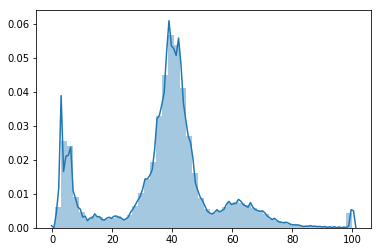

In [9]:
sns.distplot(dists)
plt.show()

## Tuning the Threshold Considered a Match

In [73]:
##Used this code to see how different thresholds would group the meals. To reproduce, execute below
##otherwise load in pkl file

parameter_tuning = {}
mat = squareform(dists)
parameter_tuning['dists'] = dists
parameter_tuning['mat'] = mat
parameter_tuning['test_thresholds'] = range(65,70,1)
for i in range(65,70,1):
    thresh = buildThreshholdMatrix(mat, i)
    groups = categorizeIntoClusters(thresh)
    num = len(groups)
    parameter_tuning[i] = {}
    parameter_tuning[i]['thresh'] = thresh
    parameter_tuning[i]['groups'] = groups
    parameter_tuning[i]['num'] = num
    print('Tuned for threshold: {}, with groups: {}'.format(i, num))

with open('parameter_tuning2.pkl','wb') as file:
    pkl.dump(parameter_tuning, file)

# with open('parameter_tuning.pkl', 'rb') as cached:
#     parameter_tuning = pkl.load(cached)

Tuned for threshold: 65, with groups: 57
Tuned for threshold: 66, with groups: 63
Tuned for threshold: 67, with groups: 70
Tuned for threshold: 68, with groups: 74
Tuned for threshold: 69, with groups: 80


In [76]:
df2 = df.copy()
clusters = []
for i in parameter_tuning['test_thresholds']:
    df2 = addGroupsToDF(df2, parameter_tuning[i]['groups'], i)
    clusters.append(getClusterName(i))

In [77]:
df2.head()

,date,type,traditional,cluster_t65,cluster_t66,cluster_t67,cluster_t68,cluster_t69
0,2014-08-31,Breakfast,XXX Bacon; Cage Free Fried Egg; XXX Fresh Frui...,0,0,0,0,0
1,2014-08-31,Lunch,Apple Cranberry Chutney; Steamed Broccoli; Cag...,0,0,0,0,0
2,2014-08-31,Dinner,Delmonico Potatoes; Salmon; Gratin of Seasonal...,18,18,18,17,17
3,2014-09-01,Breakfast,XXX Bacon; French Dipped Waffles; Cage Free Fr...,0,0,0,0,0
4,2014-09-01,Lunch,Garlic and Herb Breadsticks; Steamed Broccoli;...,23,23,23,23,24


In [78]:
df3 = df2.copy()
for cluster in clusters:
    df3 = tagDF(df3, cluster)

/Users/Alex/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [79]:
df3.head()

,date,type,traditional,cluster_t65,cluster_t66,cluster_t67,cluster_t68,cluster_t69,tag_cluster_t65,tag_cluster_t66,tag_cluster_t67,tag_cluster_t68,tag_cluster_t69
0,2014-08-31,Breakfast,XXX Bacon; Cage Free Fried Egg; XXX Fresh Frui...,0,0,0,0,0,free cage egg; scrambled bacon; hard boiled,free cage egg; scrambled bacon; boiled hard,free cage egg; scrambled bacon; boiled hard,free cage egg; scrambled bacon; hard boiled,cage free egg; scrambled bacon; hard boiled
1,2014-08-31,Lunch,Apple Cranberry Chutney; Steamed Broccoli; Cag...,0,0,0,0,0,free cage egg; scrambled bacon; hard boiled,free cage egg; scrambled bacon; boiled hard,free cage egg; scrambled bacon; boiled hard,free cage egg; scrambled bacon; hard boiled,cage free egg; scrambled bacon; hard boiled
2,2014-08-31,Dinner,Delmonico Potatoes; Salmon; Gratin of Seasonal...,18,18,18,17,17,delmonico salmon; seasonal gratin of vegetables;,delmonico salmon; seasonal gratin of vegetables;,delmonico salmon; seasonal gratin of vegetables;,delmonico salmon; seasonal gratin of vegetables;,delmonico salmon; seasonal gratin of vegetables;
3,2014-09-01,Breakfast,XXX Bacon; French Dipped Waffles; Cage Free Fr...,0,0,0,0,0,free cage egg; scrambled bacon; hard boiled,free cage egg; scrambled bacon; boiled hard,free cage egg; scrambled bacon; boiled hard,free cage egg; scrambled bacon; hard boiled,cage free egg; scrambled bacon; hard boiled
4,2014-09-01,Lunch,Garlic and Herb Breadsticks; Steamed Broccoli;...,23,23,23,23,24,steamed broccoli herb and garlic chicken,chicken herb and broccoli steamed garlic,chicken herb and broccoli steamed garlic,chicken herb and broccoli steamed garlic,chicken herb and broccoli steamed garlic


In [80]:
with open('val_clustered_65_70.csv', 'w+') as file:
    df3.to_csv(file)

In [1]:
import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler

In [14]:
centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(n_samples=750, centers=centers, cluster_std=0.4,
                            random_state=0)

In [15]:
X

array([[ 0.84022039,  1.14802236],
       [-1.15474834, -1.2041171 ],
       [ 0.67863613,  0.72418009],
       ..., 
       [ 0.26798858, -1.27833405],
       [-0.88628813, -0.30293249],
       [ 0.60046048, -1.29605472]])

In [18]:
X = StandardScaler().fit_transform(X)

In [19]:
X

array([[ 0.49426097,  1.45106697],
       [-1.42808099, -0.83706377],
       [ 0.33855918,  1.03875871],
       ..., 
       [-0.05713876, -0.90926105],
       [-1.16939407,  0.03959692],
       [ 0.26322951, -0.92649949]])

In [28]:
mat = squareform(dists)

In [29]:
mat

array([[  0.,  60.,  31., ...,  59.,  43.,  42.],
       [ 60.,   0.,  38., ...,  55.,  44.,  45.],
       [ 31.,  38.,   0., ...,  32.,  42.,  41.],
       ..., 
       [ 59.,  55.,  32., ...,   0.,  35.,  40.],
       [ 43.,  44.,  42., ...,  35.,   0.,  48.],
       [ 42.,  45.,  41., ...,  40.,  48.,   0.]])

In [30]:
mat2 = StandardScaler().fit_transform(mat)

In [32]:
mat3 = mat/100

In [33]:
mat3

array([[ 0.  ,  0.6 ,  0.31, ...,  0.59,  0.43,  0.42],
       [ 0.6 ,  0.  ,  0.38, ...,  0.55,  0.44,  0.45],
       [ 0.31,  0.38,  0.  , ...,  0.32,  0.42,  0.41],
       ..., 
       [ 0.59,  0.55,  0.32, ...,  0.  ,  0.35,  0.4 ],
       [ 0.43,  0.44,  0.42, ...,  0.35,  0.  ,  0.48],
       [ 0.42,  0.45,  0.41, ...,  0.4 ,  0.48,  0.  ]])

In [72]:
db = DBSCAN(eps=0.1, min_samples=2, metric = 'precomputed').fit(mat3)
labels = db.labels_
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)

Estimated number of clusters: 1


Estimated number of clusters: 0


In [36]:
db

DBSCAN(algorithm='auto', eps=0.3, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=10, n_jobs=1, p=None)